All Networks and Features together

**Install Requirements**

In [ ]:
!pip install hazm
!pip install nlpaug
!pip install stanza
!pip install requests
!pip install python-bidi
!pip install transformers

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


**Declare Required Paths**

In [ ]:
dataset_path = '/content/drive/MyDrive/Stance Detection/Own/HeadlineToClaim.csv'
stopWord_path = '/content/drive/MyDrive/Stance Detection/Own/StopWords_fa.txt'
save_load_path = "/content/drive/MyDrive/Stance Detection/Own/vectors"
MODEL_NAME_OR_PATH = 'HooshvareLab/bert-fa-base-uncased'

**Import Section**

In [ ]:
import os
import re
import time
import nltk
import random
import stanza
import string
import joblib
import pprint
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline


from hazm import *
from tqdm.notebook import tqdm
from difflib import SequenceMatcher
import nlpaug.augmenter.word as naw
from bidi.algorithm import get_display
from scipy.spatial.distance import cosine
from nltk import word_tokenize as nltk_word_tokenize

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import torch
import torch.nn as nn
# import torch.nn.functional as F
from torch.optim import SGD
from transformers import BertTokenizer, BertModel
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import BertForSequenceClassification , BertConfig
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler


# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicConfig(level=logging.INFO)

**Declare Handmade Necessaries**

In [ ]:
# INPUT_PREFERENCE = 'Single sentence'
INPUT_PREFERENCE = 'Couple sentence'

ADD_EXTRA_FAETURES = True

BERT_ONLY = True

AUGMENTATION = True

if (BERT_ONLY == True):
  ADD_EXTRA_FAETURES = False

In [ ]:
fa_punctuations = ['،','«','»',':','؛','ْ','ٌ','ٍ','ُ','ِ','َ','ّ','ٓ','ٰ','-','*']
important_words = ['؟','تکذیب', 'تکذیب شد', ':',]

In [ ]:
refute_hedge_reporte_words = ['جعلی',
                   'تقلب',
                   'فریب',
                   'حیله',
                   'کلاهبرداری',
                   'شیادی',
                   'دست انداختن',
                   'گول زدن',
                   'نادرست',
                   'غلط',
                   'کذب',
                   'ساختگی',
                   'قلابی',
                   'انکار',
                   'رد',
                   'تکذیب',
                   'تکذیب کردن',
                   'تکذیب شد',
                   'انکار کردن'
                   'انکار می کند',
                   'نه',
                   'با وجود',
                   'علیرغم',
                   'با اینکه',
                   'شک داشتن',
                   'تردید کردن',
                   'مظنون بودن',
                   'شک',
                   'تردید',
                   'دو دلی',
                   'گمان',
                   'به گزارش'
                   ,'ادعا شده'
                   ,'به قول معروف'
                   ,'بنا به گفته'
                   , 'ظاهرا'
                   ,'به نظر می رسد'
                   ,'ادعا'
                   ,'میتوانست'
                   ,'می تواند'
                   ,'از قرار معلوم'
                   ,'مشخصا'
                   ,'تا حد زیادی'
                   ,'احتمال دارد'
                   ,'شاید'
                   ,'به طور عمده'
                   ,'ممکن است'
                   ,'گویا'
                   ,'ممکن'
                   ,'اغلب'
                   ,'غالبا'
                   ,'احتمالا'
                   ,'احتمالاً'
                   ,'محتملا'
                   ,'گفته شده'
                   ,'گزارش داد'
                   ,'طبق گزارش'
                   ,'شایعه'
                   ,'شایعات'
                   ,'شایعه شده'
                   ,'قدری'
                   ,'تا حدی'
                   ,'تأیید نشده'
]

In [ ]:
if (ADD_EXTRA_FAETURES == True):
  stanza.download('fa')

**Functions**

**Preproccessing Data**

In [ ]:
def clean_sentence(sentence):

  normalizer = Normalizer()
  shayee = normalizer.normalize("شایعه")
  clean_sentences = sentence
  re_pattern1 = "(/(\s)*"+ shayee +"(\s)*[0-9]+)|(/(\s)*شایعه(\s)*[0-9]+)"
  re_pattern2 = "/(\s)*[0-9]+"
  re_pattern3 = "\\u200c|\\u200d|\\u200e|\\u200b|\\u2067|\\u2069"
  x = re.search(re_pattern1, sentence)
  if (x):
    clean_sentences = re.sub(re_pattern1, "", sentence)
    
  x = re.search(re_pattern2, clean_sentences)
  if (x):
    clean_sentences = re.sub(re_pattern2, "", clean_sentences)
        
  x = re.search(re_pattern3, clean_sentences)
  if (x):
    clean_sentences = re.sub(re_pattern3, "", clean_sentences)   
        
  punc_regex = re.compile('|'.join(map(re.escape, list(string.punctuation) + list(fa_punctuations))))

  clean_sentences = punc_regex.sub("", clean_sentences)

  return clean_sentences

In [ ]:
def clean_tokens(target_list):
    assert isinstance(target_list, (list)) == True , "Type of target_list is not correct. It has to be list."
    normalizer = Normalizer()

    denide_words = fa_stop_words + list(string.punctuation) + list(fa_punctuations)
            
    clean_words = []

    for item in target_list:
      clean_words.append([i for i in item if normalizer.normalize(i) not in denide_words])
    return clean_words

**Split Dataset**

In [ ]:
def load_data(df):

    trainset = df[df.data_type=='train']

    valset = df[df.data_type=='val']

    testset = df[df.data_type=='test']

    return trainset, valset, testset

**Classes Distribution**

In [ ]:
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    # return "{:.1f}%\n({:d} N.)".format(pct, absolute)
    return "{:.1f}%".format(pct, absolute)

In [ ]:
def classes_distribution(df):

  First_Categories = list(set(df.stance))
  k = dict()
  for CG in list(df.stance):
    if CG not in k.keys():
      k[CG] = 1
    else:
      k[CG] += 1
  pprint.pprint(k)
  print('Number of Rows: ',sum(k.values()))

  Categories_Data = list(k.values())
  Categories = [z for z in list(k.keys())]
  Categories = [get_display(i) for i in Categories]
  # explode = (0.1, 0.0, 0.2, 0.3, 0.0, 0.0)
  colors = ( "orange", "cyan", "brown","yellow", "purple", "beige", "pink")
  wp = { 'linewidth' : 1, 'edgecolor' : "black" }

  fig, ax = plt.subplots(figsize =(12, 9))
  wedges, texts, autotexts = ax.pie(Categories_Data, 
                                    autopct = lambda pct: func(pct, Categories_Data),
                                    labels = Categories,
                                    shadow = False,
                                    # explode = explode,
                                    colors = colors,
                                    startangle = 180,
                                    wedgeprops = wp,
                                    textprops = dict(color ="black"))
    
  ax.legend(wedges, Categories,
            title ="Categories",
            loc ="center",
            bbox_to_anchor =(1.3, 0, 0.5, 1)) 
  plt.setp(autotexts, size = 8, weight ="bold")
  ax.set_title("Pie Chart of Categories")
  plt.show()


**Feature Generation**

In [ ]:
def generate_Features( data_df, save_path, load_path, save_feature = False, load_if_exist = True,
                       senteces_similarity = True, important_words = True,
                       is_question = True, more_than2_parts = True, 
                       root_distance = True, w2v = True , bow = True ,tfidf = True):
  
    features = data_df['question'].values
    features = np.reshape(features,(len(features),1))

    print(features.shape)

    hasTowParts = data_df['part'].values
    print(len(hasTowParts))
    clean_claims = data_df['clean_claim'].values
    print(len(clean_claims))
    clean_headlines = data_df['clean_headline'].values
    print(len(clean_headlines))
    clean_claims_headlines = data_df['cln_clm_hdln'].values
    print(len(clean_claims_headlines))

    print(len(clean_headlines))


    file_name = ''

    if load_if_exist == True or save_feature == True:
      if tfidf:
        file_name += 'tfidf_'
      if senteces_similarity:
        file_name += 'similarity_'
      if important_words:
        file_name += 'important_words_'        
      if is_question:
        file_name += 'is_question_'
      if more_than2_parts:
        file_name += 'more_than2_parts_'
      if root_distance:
        file_name += 'root_distance_'    
      if w2v:
        file_name += 'w2v_'     
      if bow:
        file_name += 'bow_'    


    if load_if_exist :
      assert len(load_path) > 0, "Please enter load_path."
      load_file_name = load_path + '/' + file_name + '.pkl'
      if os.path.isfile(load_file_name) == True :
        features = joblib.load(load_file_name)
        print('Features loaded successfully.')
        return features, file_name
      else:
        print('Features vector file is not exist.')
    
    # -------------- tfidf ----------
    if tfidf:
      print('Start to generate tf_idf feature')
      tf_idf_feature = tf_idf()
      features = np.append(features, tf_idf_feature ,axis = 1)
      print('End of tf_idf feature')
    # -------------- similarity ----------
    if senteces_similarity:
      print('Start to generate similarity feature')
      similarity_feature = similarity(clean_claims, clean_headlines)
      features = np.append(features, similarity_feature ,axis = 1)
      print('End of similarity feature')
    # -------------- important words ----------
    if important_words:
      print('Start to generate important words feature')
      important_words_feature = calc_important_words(clean_claims_headlines)
      features = np.append(features, important_words_feature ,axis = 1)
      print('End of important words feature')
    # -------------- is question ----------
    if is_question == False:
      features = features[:,1:]
    else:
      print('"is question" feature was added.')
    # -------------- more than tow parts ----------
    if more_than2_parts:
      features = np.append(features, np.reshape(hasTowParts, (len(hasTowParts),1)) ,axis = 1)
      print('"more than tow parts" feature was added.')
    # -------------- root distance ----------
    if root_distance:
      print('Start to generate root distance feature')
      root_distance_feature = calculate_root_distance(clean_headlines)
      features = np.append(features, root_distance_feature ,axis = 1)
      print('End of root distance feature')  
    # -------------- w2v ----------
    # if w2v:
    #   print('Start to generate w2v feature')
    #   assert len(w2v_model_path) > 0, "Please enter w2v_model_path."
    #   w2v_model = joblib.load(w2v_model_path)
    #   w2v_feature = get_w2v_feature(w2v_model, num_features = 300)
    #   w2v_feature = (w2v_feature - np.min(w2v_feature))/ (np.max(w2v_feature) - np.min(w2v_feature))
    #   features = np.append(features, w2v_feature ,axis = 1)
    #   print('End of w2v feature')   
    # -------------- bow ----------
    if bow:
      print('Start to generate bow feature')
      bow_feature = get_bow(clean_claims_headlines)
      features = np.append(features, bow_feature ,axis = 1)
      print('End of bow feature')          
    
    if save_feature:
      joblib.dump(features, (save_path + '/' + file_name + '.pkl'))
      print('Features saved successfully.')          
    return features, file_name

In [ ]:
def tf_idf():
    tfidf = TfidfVectorizer(sublinear_tf=True, min_df=10, norm='l2', ngram_range=(1, 2))
    features = tfidf.fit_transform(clean_claims_headlines).toarray() 
    return features
  # --------------------------------------------------
def similarity(clean_claims, clean_headlines):
    feature = []
    for i, (claim,headline) in enumerate(zip(clean_claims, clean_headlines)):
      ratio = SequenceMatcher(None, claim, headline).ratio()
      quick_ratio = SequenceMatcher(None, claim, headline).quick_ratio()
      real_quick_ratio = SequenceMatcher(None, claim, headline).real_quick_ratio()
      feature.append([ratio,quick_ratio,real_quick_ratio])
    return feature    
  # --------------------------------------------------
def calc_important_words(clean_claims_headlines):
    assert (important_words != None), 'For calculating important words you should pass important words in initializer.'
    features = np.zeros((len(clean_claims_headlines), len(important_words)))
    for i in range(len(clean_claims_headlines)):
      for j in range(len(important_words)):
        if important_words[j] in clean_claims_headlines[i]:
            features[i][j] = 1
    return features
  # --------------------------------------------------
def calculate_root_distance(clean_headlines, target_sentences = None): # target_sentences = clean_headlines
    
    if target_sentences == None:
      target_sentences = clean_headlines
    
    # nlp = stanfordnlp.Pipeline(lang='fa', models_dir= self.stanford_models_path, treebank=None, use_gpu=True) 
    nlp = stanza.Pipeline(lang='fa')#, models_dir= self.stanza_models_path) #, treebank=None, use_gpu=True) 
    root_distance_feature = np.zeros((len(target_sentences),1))
    for index,headline in enumerate(target_sentences):
      root_distance_feature[index] = -1
      doc = nlp(headline)
    #   root = [(i,doc.sentences[0].words[i].text) for i in range(len(doc.sentences[0].words)) if  doc.sentences[0].words[i].dependency_relation == 'root' ]
      root = [(i,doc.sentences[0].words[i].text) for i in range(len(doc.sentences[0].words)) if  doc.sentences[0].words[i].deprel == 'root' ]
      if(len(root) == 0):
        continue

      root_index,root_word = root[0]

      for word_index,word in enumerate(headline.split()) :
        target = [(i,refute_hedge_reporte_words[i]) for i in range(len(refute_hedge_reporte_words)) if  refute_hedge_reporte_words[i] == word]
        if(len(target) > 0):
          target_index, target_word =target[0]
          root_distance_feature[index] = abs(word_index - root_index)
          break
    return root_distance_feature
  # --------------------------------------------------

def get_bow(clean_claims_headlines, target_sentences = None):
    if target_sentences == None:
      target_sentences = clean_claims_headlines
    vectorizer = CountVectorizer(ngram_range=(1, 1))
    X = vectorizer.fit_transform(target_sentences)
    return X.toarray()

In [ ]:
def create_features_tensors(df):
  
  # temp_df =  features_df[features_df.data_type==mode]
  temp_df = df.drop(['data_type'], axis=1)
  

  features_list = []
  for i in range(len(temp_df.index)):
    features_list.append(temp_df.iloc[i])

  features_tensor = torch.tensor(features_list, dtype = torch.double)
  return features_tensor

**Data Augmentation**

In [ ]:
def text_augmentor(sentences):
  
  return aug.augment(list(sentences))

**Tokenizing**

In [ ]:
def encoding_phase(data):
  if (INPUT_PREFERENCE == 'Couple sentence'):
   
    encoded_data = parsBERT_tokenizer(
        list(data['clean_claim']), 
        list(data['clean_headline']), 
        add_special_tokens=True, 
        return_attention_mask=True, 
        pad_to_max_length=True, 
        max_length=36, 
        return_tensors='pt',
        truncation=True
    )
  else:
    encoded_data = parsBERT_tokenizer.batch_encode_plus(
        list(data['cln_clm_hdln']), 
        add_special_tokens=True, 
        return_attention_mask=True, 
        pad_to_max_length=True, 
        max_length=36, 
        return_tensors='pt',
        truncation=True
    )
  return encoded_data

**Tensor Detaset**

In [ ]:
def create_tensor_dataset(data, features_df=None):

  encoded_data = encoding_phase(data)

  input_ids = encoded_data['input_ids']
  attention_masks = encoded_data['attention_mask']
  token_type_ids = encoded_data['token_type_ids']
  labels = torch.tensor(data.label.values)

  if (ADD_EXTRA_FAETURES == True):
    
    extra_features = create_features_tensors(features_df)
    return TensorDataset(input_ids, attention_masks, token_type_ids, extra_features, labels)
  
  return TensorDataset(input_ids, attention_masks, token_type_ids, labels)

**Score Calculations**

In [ ]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

**Calculating Time**

In [ ]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

**Create Status DataFrame**

In [ ]:
def create_status_dataFrame(training_status, lr, eps, epochs, batch_size):
  
  # Display floats with two decimal places.
  pd.set_option('precision', 2)

  # Create a DataFrame from our training statistics.
  df_status = pd.DataFrame(data=training_status)

  df_status['lr'] = lr
  df_status['eps'] = eps
  df_status['num_epochs'] = epochs
  df_status['batch size'] = batch_size


  # Use the 'epoch' as the row index.
  # df_status = df_status.set_index('Epoch')

  return df_status

**Plotting Function**

In [ ]:
def plot_evaluations(mode, df):
  
  if (mode == 'F1'):
    y_training_plt = df['Training Eval. F1']
    y_val_plt = df['Valid. F1'] 
    title_plt = "Training & Validation F1"
    y_label_plt = "F1"

  elif (mode == 'Loss'):
    y_training_plt = df['Training Loss']
    y_val_plt = df['Valid. Loss'] 
    title_plt = "Training & Validation Loss"
    y_label_plt = "Loss"

  elif (mode == 'Acc'):
    y_training_plt = df['Training Eval. Acc.']
    y_val_plt = df['Valid. Acc.'] 
    title_plt = "Training & Validation Acc."
    y_label_plt = "Accuracy"

  # Use plot styling from seaborn.
  sns.set(style='darkgrid')

  # Increase the plot size and font size.
  sns.set(font_scale=1.5)
  plt.rcParams["figure.figsize"] = (12,6)

  # Plot the learning curve.
  plt.plot(y_training_plt, 'b-o', label="Training")
  plt.plot(y_val_plt, 'g-o', label="Validation")

  # Label the plot.
  plt.title(title_plt)
  plt.xlabel("Epoch")
  plt.ylabel(y_label_plt)
  plt.legend()
  plt.xticks([1, 2, 3, 4])

  plt.show()


In [ ]:
def plot_proformance(df):
  titles = ["Loss", "Accuracy", "F1-Score"]
  fig,axes = plt.subplots(1, 3)
  fig.suptitle("Model Performance")
  fig.set_size_inches(20, 5)
  yvalues_train = [df['Training Loss'], df['Training Eval. Acc.'], df['Training Eval. F1']]
  yvalues_val = [df['Valid. Loss'], df['Valid. Acc.'], df['Valid. F1']]
  # xlabel = "Epoch"
  
  for i, ax in enumerate(axes):
    ax.plot(yvalues_train[i], 'b-o', label="Training")
    ax.plot(yvalues_val[i], 'g-o', label="Validation")
    ax.set_title(titles[i])
    # ax.xlabel("Epoch")
    ax.legend()
    ax.grid(True)
  plt.setp(axes, xlabel='Epoch')
  plt.show()

In [ ]:
def report(mode, predictions, true_vals):

  print("####### Report on ", mode, " #######")
  
  print("\nAccuracy per class:") 
  accuracy_per_class(predictions, true_vals)
  print("************************")

  preds_flat = np.argmax(predictions, axis=1).flatten()
  print("\nClassification Report: \n", classification_report(true_vals, preds_flat))
  print("************************")

  conf_mat = confusion_matrix(true_vals, preds_flat)
  print("\nConfusion Matrix: \n")
  print(conf_mat)
  print("\n")
  plt.imshow(conf_mat)

<body>      
         <h1 style="font-size:40px;"><b>Main</h1>         
      </body>

**Reading Dataset**

In [ ]:
dataset = pd.read_csv(dataset_path, encoding = 'utf-8')
claims = dataset['claim'].values
headlines = dataset['headline'].values
isQuestion = dataset['question'].values
hasTowParts = dataset['part'].values
labels = dataset['label'].values
assert (claims.shape == headlines.shape == isQuestion.shape == labels.shape == hasTowParts.shape), "The features size are not equal."
print(claims.shape , headlines.shape ,isQuestion.shape,hasTowParts.shape ,labels.shape)

(2029,) (2029,) (2029,) (2029,) (2029,)


**Reading Persian Stop Words**

In [ ]:
normalizer = Normalizer()
fa_stop_words = list()
print(stopWord_path)
with open(stopWord_path) as f:
  for line in f:
    fa_stop_words.append(normalizer.normalize(line.rstrip("\n\r")))

/content/drive/MyDrive/Stance Detection/Own/StopWords_fa.txt


**Cleaning Sentences**

In [ ]:
clean_claims = []
clean_headlines = []
for claim,headline in zip(claims, headlines):
  clean_claims.append(clean_sentence(claim))
  clean_headlines.append(clean_sentence(headline))

print(len(clean_claims))
print(len(clean_headlines))

dataset['clean_claim'] = clean_claims
dataset['clean_headline'] = clean_headlines
dataset['cln_clm_hdln'] = dataset['clean_claim'] + " " + dataset['clean_headline']
clean_claims_headlines = dataset['cln_clm_hdln']

2029
2029


**Encoding the Labels**

In [ ]:
possible_labels = dataset.label.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
print(label_dict)

dataset = dataset.rename(columns = {'label':'stance'})
dataset['label'] = dataset.stance.replace(label_dict)

{'Discuss': 0, 'Unrelated': 1, 'Agree': 2, 'Disagree': 3}


**Spliting Data in Train/Test/Validation**

In [ ]:
X_train_all, X_test, y_train_all, y_test = train_test_split(dataset.index.values, 
                                                  dataset.label.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=dataset.label.values)

X_train, X_val, y_train, y_val = train_test_split(X_train_all, 
                                                  y_train_all, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=y_train_all)

In [ ]:
dataset['data_type'] = ['not_set']*dataset.shape[0]

dataset.loc[X_train, 'data_type'] = 'train'
dataset.loc[X_val, 'data_type'] = 'val'
dataset.loc[X_test, 'data_type'] = 'test'

dataset.groupby(['stance', 'label', 'data_type']).count()

index  claim  ...  clean_headline  cln_clm_hdln
stance    label data_type                ...                              
Agree     2     test          61     61  ...              61            61
                train        292    292  ...             292           292
                val           52     52  ...              52            52
Disagree  3     test          25     25  ...              25            25
                train        118    118  ...             118           118
                val           21     21  ...              21            21
Discuss   0     test         120    120  ...             120           120
                train        580    580  ...             580           580
                val          102    102  ...             102           102
Unrelated 1     test          99     99  ...              99            99
                train        475    475  ...             475           475
                val           84     84  ...              84            84

[12 rows x 9 columns]

In [ ]:
print(len(X_train))
print(len(X_val))
print(len(X_test))

1465
259
305


**Extracting Extra Feature --- Original Data**

In [ ]:
if (ADD_EXTRA_FAETURES == True):
  features, file_name = generate_Features(dataset, save_path=save_load_path, load_path=save_load_path, save_feature = True, load_if_exist = True, 
                              senteces_similarity = True, important_words = True,
                              is_question = True, more_than2_parts = True, 
                              root_distance = True, w2v = False , bow = True ,tfidf = False)
  print(features.shape)
  print(file_name)

In [ ]:
if (ADD_EXTRA_FAETURES == True):
  features_df = pd.DataFrame(features)
  features_df['data_type'] = dataset['data_type']
  features_df.info()

**Load Data in different Datasets**

In [ ]:
train_dataset, val_dataset, test_dataset = load_data(dataset)

**Data Augmentation**

In [ ]:
if (AUGMENTATION == True):
  aug = naw.ContextualWordEmbsAug(model_path=MODEL_NAME_OR_PATH, action="insert")

Downloading:   0%|          | 0.00/440 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/624M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Classes distribution before augmentation on train set:
{'Agree': 292, 'Disagree': 118, 'Discuss': 580, 'Unrelated': 475}
Number of Rows:  1465


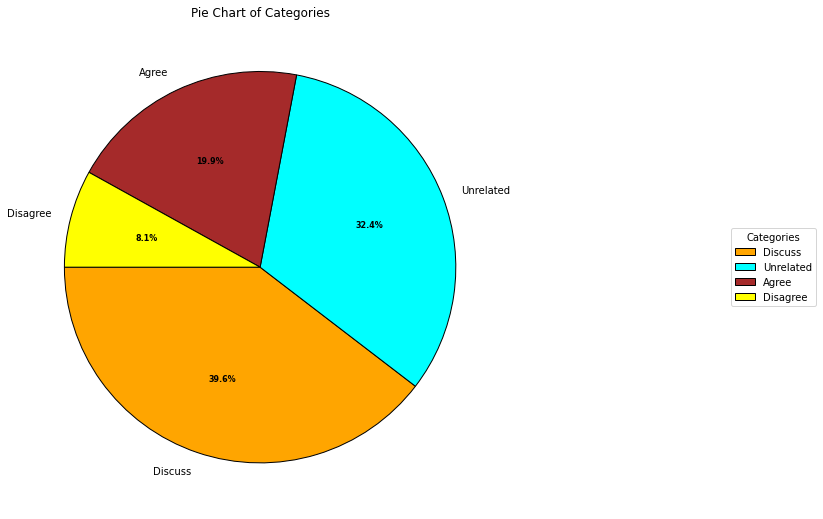

In [ ]:
if (AUGMENTATION == True):
  print("Classes distribution before augmentation on train set:")
  classes_distribution(train_dataset)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   clean_claim     30 non-null     object
 1   clean_headline  30 non-null     object
 2   cln_clm_hdln    30 non-null     object
 3   question        30 non-null     int64 
 4   part            30 non-null     int64 
 5   stance          30 non-null     object
 6   label           30 non-null     int64 
dtypes: int64(3), object(4)
memory usage: 1.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   clean_claim     30 non-null     object
 1   clean_headline  30 non-null     object
 2   cln_clm_hdln    30 non-null     object
 3   question        30 non-null     int64 
 4   part            30 non-null     int64 
 5   stance          30 non-null     objec

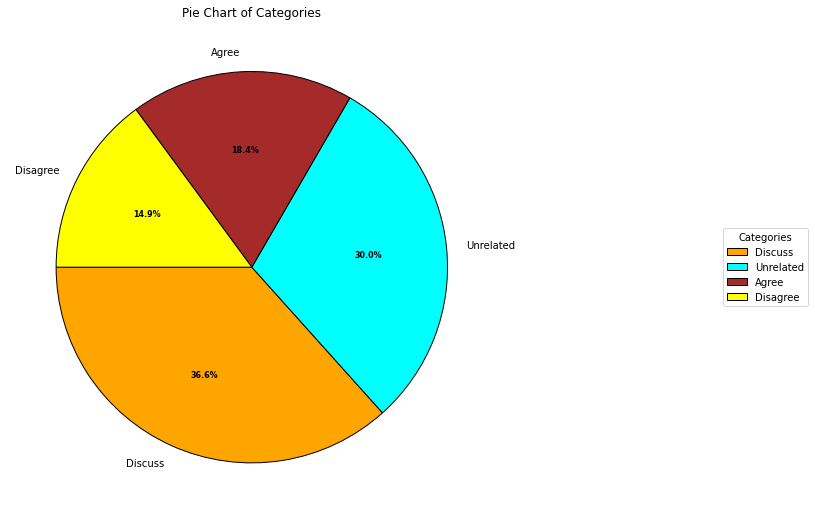

In [ ]:
# mixed augmentation
if (AUGMENTATION == True):
  disagree_train_df = train_dataset[train_dataset.stance =='Disagree']

  disagree_dataset = pd.DataFrame()

  aug = naw.ContextualWordEmbsAug(model_path=MODEL_NAME_OR_PATH, action="insert")
  disagree_dataset1 = pd.DataFrame()
  temp_disagree_train_df = disagree_train_df[:30]
  disagree_dataset1 ['clean_claim'] = text_augmentor(temp_disagree_train_df['clean_claim'])
  disagree_dataset1 ['clean_headline'] = text_augmentor(temp_disagree_train_df['clean_headline'])
  disagree_dataset1 ['cln_clm_hdln'] = text_augmentor(temp_disagree_train_df['cln_clm_hdln'])
  disagree_dataset1 ['question'] = temp_disagree_train_df['question'].values
  disagree_dataset1 ['part'] = temp_disagree_train_df['part'].values
  disagree_dataset1 ['stance'] = 'Disagree'
  disagree_dataset1 ['label'] = 3
  disagree_dataset1.info()

  aug = naw.ContextualWordEmbsAug(model_path=MODEL_NAME_OR_PATH, action="substitute")
  disagree_dataset2 = pd.DataFrame()
  temp_disagree_train_df = disagree_train_df[30:60]
  disagree_dataset2 ['clean_claim'] = text_augmentor(temp_disagree_train_df['clean_claim'])
  disagree_dataset2 ['clean_headline'] = text_augmentor(temp_disagree_train_df['clean_headline'])
  disagree_dataset2 ['cln_clm_hdln'] = text_augmentor(temp_disagree_train_df['cln_clm_hdln'])
  disagree_dataset2 ['question'] = temp_disagree_train_df['question'].values
  disagree_dataset2 ['part'] = temp_disagree_train_df['part'].values
  disagree_dataset2 ['stance'] = 'Disagree'
  disagree_dataset2 ['label'] = 3
  disagree_dataset2.info()

  aug = naw.RandomWordAug(action='swap')
  disagree_dataset3 = pd.DataFrame()
  temp_disagree_train_df = disagree_train_df[60:89]
  disagree_dataset3 ['clean_claim'] = text_augmentor(temp_disagree_train_df['clean_claim'])
  disagree_dataset3 ['clean_headline'] = text_augmentor(temp_disagree_train_df['clean_headline'])
  disagree_dataset3 ['cln_clm_hdln'] = text_augmentor(temp_disagree_train_df['cln_clm_hdln'])
  disagree_dataset3 ['question'] = temp_disagree_train_df['question'].values
  disagree_dataset3 ['part'] = temp_disagree_train_df['part'].values
  disagree_dataset3 ['stance'] = 'Disagree'
  disagree_dataset3 ['label'] = 3
  disagree_dataset3.info()

  aug = naw.RandomWordAug(action='delete')
  disagree_dataset4 = pd.DataFrame()
  temp_disagree_train_df = disagree_train_df[89:]
  disagree_dataset4 ['clean_claim'] = text_augmentor(temp_disagree_train_df['clean_claim'])
  disagree_dataset4 ['clean_headline'] = text_augmentor(temp_disagree_train_df['clean_headline'])
  disagree_dataset4 ['cln_clm_hdln'] = text_augmentor(temp_disagree_train_df['cln_clm_hdln'])
  disagree_dataset4 ['question'] = temp_disagree_train_df['question'].values
  disagree_dataset4 ['part'] = temp_disagree_train_df['part'].values
  disagree_dataset4 ['stance'] = 'Disagree'
  disagree_dataset4 ['label'] = 3
  disagree_dataset4.info()


  train_temp_df = pd.DataFrame()
  train_temp_df ['clean_claim'] = train_dataset['clean_claim']
  train_temp_df ['clean_headline'] = train_dataset['clean_headline']
  train_temp_df ['cln_clm_hdln'] = train_dataset['cln_clm_hdln']
  train_temp_df ['question'] = train_dataset['question']
  train_temp_df ['part'] = train_dataset['part']
  train_temp_df ['stance'] = train_dataset['stance']
  train_temp_df ['label'] = train_dataset['label']
  train_temp_df.info()

  disagree_dataset = pd.concat([disagree_dataset1, disagree_dataset2, disagree_dataset3, disagree_dataset4])
  disagree_dataset.info()

  frames = [train_temp_df, disagree_dataset]
  train_dataset = pd.concat(frames)
  print(train_dataset.info())

  print("Classes distribution after augmentation on train set:")
  classes_distribution(train_dataset)

In [ ]:
disagree_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118 entries, 0 to 28
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   clean_claim     118 non-null    object
 1   clean_headline  118 non-null    object
 2   cln_clm_hdln    118 non-null    object
 3   question        118 non-null    int64 
 4   part            118 non-null    int64 
 5   stance          118 non-null    object
 6   label           118 non-null    int64 
dtypes: int64(3), object(4)
memory usage: 7.4+ KB


In [ ]:
if (AUGMENTATION == True):
  if (ADD_EXTRA_FAETURES == True):
    features_augmented_data, file_name_aug = generate_Features(disagree_dataset,
                                save_path=save_load_path, load_path=save_load_path,
                                save_feature = False, load_if_exist = False, 
                                senteces_similarity = True, important_words = True,
                                is_question = True, more_than2_parts = True, 
                                root_distance = True, w2v = False , bow = True ,tfidf = False)
    print(features_augmented_data.shape)
    print(file_name_aug)

    features_augmented_df = pd.DataFrame(features_augmented_data)
    features_augmented_df['data_type'] = 'train'
    features_augmented_df.info()


**Tokenizing**

In [ ]:
parsBERT_tokenizer = BertTokenizer.from_pretrained(MODEL_NAME_OR_PATH)

**Create Tensor Dataset**

In [ ]:
if ( ADD_EXTRA_FAETURES == True):
  train_features_df, val_features_df, test_features_df = load_data(features_df)
  if (AUGMENTATION == True):
    frames = [train_features_df, features_augmented_df]
    train_features_df = pd.concat(frames)

    train_data = create_tensor_dataset(train_dataset, train_features_df)
    val_data = create_tensor_dataset(val_dataset, val_features_df)
    test_data = create_tensor_dataset(test_dataset, test_features_df)
else:
  train_data = create_tensor_dataset(train_dataset)
  val_data = create_tensor_dataset(val_dataset)
  test_data = create_tensor_dataset(test_dataset)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing

In [ ]:
# train_data = create_tensor_dataset(train_dataset, train_features_df)
# val_data = create_tensor_dataset(val_dataset, val_features_df)
# test_data = create_tensor_dataset(test_dataset, test_features_df)

<h1> Models </h1>


In [ ]:
if ( ADD_EXTRA_FAETURES == True):
  FEATURES_LENGTH = len(features_df.columns) - 1
  inputs_length = 768 + FEATURES_LENGTH # BERT outpus plus extracted features
  n_classes = 4

**Model's Functions**

In [ ]:
def prepare_dataloaders(batch_size):
  dataloader_train = DataLoader(train_data, 
                                sampler=RandomSampler(train_data), 
                                batch_size=batch_size)

  dataloader_validation = DataLoader(val_data, 
                                    sampler=SequentialSampler(val_data), 
                                    batch_size=batch_size)

  dataloader_test = DataLoader(test_data, 
                                    sampler=SequentialSampler(test_data), 
                                    batch_size=batch_size)
  return dataloader_train, dataloader_validation, dataloader_test

**Model: BERT Only**

In [ ]:
def evaluate(model, dataloader_val):

    t0 = time.time()

    # print("Start Evaluating...")

    model.eval()
    
    loss_val_total = 0
    # total_eval_accuracy = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        if (INPUT_PREFERENCE == 'Couple sentence'):
          inputs = {'input_ids':      batch[0],
                    'attention_mask': batch[1],
                    'token_type_ids': batch[2],
                    'labels':         batch[3]
                  }
        elif (INPUT_PREFERENCE == 'Single sentence'):
          inputs = {'input_ids':      batch[0],
                    'attention_mask': batch[1],
                    'labels':         batch[2]
                  }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
        
        # total_eval_accuracy += flat_accuracy(logits, label_ids)
    
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    # avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    validation_time = format_time(time.time() - t0)

    # print("Evaluation is done!")

    return loss_val_avg, predictions, true_vals, validation_time

In [ ]:
def train_model(learning_rate, optimizer_name, epsilon, epochs, batch_size):

  training_status = []

  torch.cuda.empty_cache()

  model = BertForSequenceClassification.from_pretrained(MODEL_NAME_OR_PATH,
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)
  print("----------------------------------------------------------------")
  print("\n\n\nLoading model is done!")
  
  dataloader_train, dataloader_validation, dataloader_test = prepare_dataloaders(batch_size)

  print("DataLoader declaration is done!")

  if (optimizer_name == 'AdamW'):
    optimizer = AdamW(model.parameters(), lr=learning_rate, eps=epsilon)
  
  elif (optimizer_name == 'SGD'):
    optimizer = SGD(model.parameters(), lr=learning_rate, momentum=epsilon)

  # optimizer = AdamW(model.parameters(), lr=learning_rate, eps=epsilon)
  # optimizer = SGD(model.parameters(), lr=learning_rate, momentum=epsilon)

  print("Optimizer was selected!")

  scheduler = get_linear_schedule_with_warmup(optimizer, 
                                              num_warmup_steps=0,
                                              num_training_steps=len(dataloader_train)*epochs)
  print("Schedular is set!")

  model.to(device)

  print("\nStart Training...")

  total_t0 = time.time()

  for epoch in tqdm(range(1, epochs+1)):
    
    t0 = time.time()

    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        if (INPUT_PREFERENCE == 'Couple sentence'):
          inputs = {'input_ids':      batch[0],
                    'attention_mask': batch[1],
                    'token_type_ids': batch[2],
                    'labels':         batch[3]
                  }
        elif (INPUT_PREFERENCE == 'Single sentence'):
          inputs = {'input_ids':      batch[0],
                    'attention_mask': batch[1],
                    'labels':         batch[2]
                  }     

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    training_time = format_time(time.time() - t0)

    # torch.save(model.state_dict(), f'finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            

    train_eval_loss, train_eval_predictions, train_true_vals, train_eval_time = evaluate(model, dataloader_train)
    train_eval_f1 = f1_score_func(train_eval_predictions, train_true_vals)
    train_eval_acc = flat_accuracy(train_eval_predictions, train_true_vals)
    
    val_loss, predictions, true_vals, validation_time = evaluate(model, dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    val_acc = flat_accuracy(predictions, true_vals)

    tqdm.write(f'\nTraining loss: {loss_train_avg}')
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'Training eval Acc.: {train_eval_acc}')
    tqdm.write(f'Validation Acc.: {val_acc}')
    tqdm.write(f'Training eval F1 Score (Weighted): {train_eval_f1}')
    tqdm.write(f'Validation F1 Score (Weighted): {val_f1}')
    tqdm.write(f'Training this epoch took: {training_time}')
    
    training_status.append(
        {
            'Epoch': epoch,
            'Training Loss': loss_train_avg,
            'Valid. Loss': val_loss,
            'Training Eval. Acc.': train_eval_acc,
            'Valid. Acc.': val_acc,
            'Training Eval. F1': train_eval_f1,
            'Valid. F1': val_f1,
            'Training Time': training_time,
            'Validation Time': validation_time
        })
    
  print("Training Done!")
  print("Total training took {:} (h:mm:ss)\n\n\n".format(format_time(time.time()-total_t0)))
  print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%\n\n")
  return training_status, predictions, true_vals, dataloader_test, model

**Model: BERT + MLP**

In [ ]:
class StanceClasiifier(nn.Module):

  def __init__(self, bert_model):
    
    super().__init__()
    self.hidden1 = nn.Linear(inputs_length, 700)
    self.hidden2 = nn.Linear(700, 700)
    # self.hidden3 = nn.Linear(700, 700)
    self.output = nn.Linear(700, n_classes)

    self.relu1 = nn.ReLU()
    self.relu2 = nn.ReLU()
    # self.relu3 = nn.ReLU()
    self.dropout1 = nn.Dropout(p=0.5)
    self.dropout2 = nn.Dropout(p=0.5)
    # self.dropout3 = nn.Dropout(p=0.5)
    # self.batchnorm1 = nn.BatchNorm1d(700)
    self.bert = bert_model

  def forward(self, x):
    x = self.hidden1(x)
    # x = self.batchnorm1(x)
    x = self.dropout1(x)
    x = self.relu1(x)
    x = self.hidden2(x)
    x = self.dropout2(x)
    x = self.relu2(x)
    # x = self.hidden3(x)
    # x = self.dropout3(x)
    # x = self.relu3(x)

    x = self.output(x)
    return x


In [ ]:
def evaluate_BERT_MLP(model, dataloader_val, loss_function):

    t0 = time.time()

    print("Start Evaluating...")

    model.eval()
    
    loss_val_total = 0
    # total_eval_accuracy = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        input_ids, attention_mask, token_type_ids, extra_features, labels = tuple(b.to(device) for b in batch)

        with torch.no_grad():        
            output = model.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            embeddings = output[1][0]
            embeddings = embeddings.mean(dim=1).double() 

            features_comb = torch.cat((embeddings, extra_features), dim=1)

            outputs = model(features_comb)

            loss = loss_function(outputs, labels)
            loss_val_total += loss

        logits = outputs.detach().cpu().numpy()
        label_ids = labels.cpu().numpy()    
        predictions.append(logits)
        true_vals.append(label_ids)
        
        # total_eval_accuracy += flat_accuracy(logits, label_ids)
    
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    # avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    validation_time = format_time(time.time() - t0)

    # print("Evaluation is done!")

    return loss_val_avg, predictions, true_vals, validation_time

In [ ]:
def train_BERT_MLP_model(learning_rate, optimizer_name, epsilon, epochs, batch_size):

  training_status = []

  torch.cuda.empty_cache()

  config = BertConfig.from_pretrained(MODEL_NAME_OR_PATH, num_labels=len(label_dict), output_hidden_states=True)
  bert = BertForSequenceClassification.from_pretrained(MODEL_NAME_OR_PATH, config=config)
  bert.to(device)
  print("----------------------------------------------------------------")
  print("\n\n\nLoading model is done!")

  model = StanceClasiifier(bert)
  model.double().to(device)
  
  
  dataloader_train, dataloader_validation, dataloader_test = prepare_dataloaders(batch_size)
  print("DataLoader declaration is done!")

  loss_function = nn.CrossEntropyLoss()
  print("Loss Function was declared!")

  if (optimizer_name == 'AdamW'):
    optimizer = AdamW(model.parameters(), lr=learning_rate, eps=epsilon)
  
  elif (optimizer_name == 'SGD'):
    optimizer = SGD(model.parameters(), lr=learning_rate, momentum=epsilon)

  # optimizer = AdamW(model.parameters(), lr=learning_rate, eps=epsilon)
  # optimizer = SGD(model.parameters(), lr=learning_rate, momentum=epsilon)

  print("Optimizer was selected!")

  # scheduler = get_linear_schedule_with_warmup(optimizer, 
  #                                             num_warmup_steps=0,
  #                                             num_training_steps=len(dataloader_train)*epochs)
  # print("Schedular is set!")

  # model.to(device)

  print("\nStart Training...")

  total_t0 = time.time()

  for epoch in tqdm(range(1, epochs+1)):
    
    t0 = time.time()

    model.train()
    
    loss_train_total = 0
    train_accuracy = 0
    predictions, true_vals = [], []

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        input_ids, attention_mask, token_type_ids, extra_features, labels = tuple(b.to(device) for b in batch)

        optimizer.zero_grad()

        # Run input IDs and masks through BERT first to get embeddings
        # then combine with BOW to run through rest of nnet model
        outputs = model.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        # output[1] are the hidden states.
        embeddings = outputs[1][0]
        embeddings = embeddings.mean(dim=1).double() 
        # print("embedding shape: ", embeddings.size())

        features_comb = torch.cat((embeddings, extra_features), dim=1)
        # print("features shape: ", features_comb.size())

        outputs = model(features_comb)
        vals, inds = torch.max(outputs, dim=1)
        
        loss = loss_function(outputs, labels)
        loss_train_total += loss
        
        # outputs = outputs.detach().cpu().numpy()
        # labels = labels.cpu().numpy()
        # predictions.append(outputs)
        # true_vals.append(labels)

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        loss.backward()
        optimizer.step()
        # scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss/len(batch))})
         
        
    training_time = format_time(time.time() - t0)

    # torch.save(model.state_dict(), f'finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)

    train_eval_loss, train_eval_predictions, train_true_vals, train_eval_time = evaluate_BERT_MLP(model, dataloader_train, loss_function)
    train_eval_f1 = f1_score_func(train_eval_predictions, train_true_vals)
    train_eval_acc = flat_accuracy(train_eval_predictions, train_true_vals)
    
    val_loss, predictions, true_vals, validation_time = evaluate_BERT_MLP(model, dataloader_validation, loss_function)
    val_f1 = f1_score_func(predictions, true_vals)
    val_acc = flat_accuracy(predictions, true_vals)

    tqdm.write(f'\nTraining loss: {loss_train_avg}')
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'Training eval Acc.: {train_eval_acc}')
    tqdm.write(f'Validation Acc.: {val_acc}')
    tqdm.write(f'Training eval F1 Score (Weighted): {train_eval_f1}')
    tqdm.write(f'Validation F1 Score (Weighted): {val_f1}')
    tqdm.write(f'Training this epoch took: {training_time}')
    
    training_status.append(
        {
            'Epoch': epoch,
            'Training Loss': loss_train_avg,
            'Valid. Loss': val_loss,
            'Training Eval. Acc.': train_eval_acc,
            'Valid. Acc.': val_acc,
            'Training Eval. F1': train_eval_f1,
            'Valid. F1': val_f1,
            'Training Time': training_time,
            'Validation Time': validation_time
        })
    
  print("Training Done!")
  print("Total training took {:} (h:mm:ss)\n\n\n".format(format_time(time.time()-total_t0)))
  print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%\n\n")
  return training_status, predictions, true_vals, dataloader_test, model, loss_function

**Models Run Function -- For easy run**

In [ ]:
def run_model():

  if (BERT_ONLY == True):
    model_choice = 'BERT'
  else:
    model_choice = 'BERT + MLP'
  configuration = {
                'Model': model_choice,    
                'Optimizer': optimizer_choice,
                'Epochs': number_of_epochs,
                'Batch size': batch_size,
                'Learning rate': lr,
                'Momentum/Eps': eps 
            }
  
  print(configuration)
  if (BERT_ONLY == True):
    training_status, predictions, true_vals, dataloader_test, model = train_model(learning_rate=lr,
                                                                                  optimizer_name=optimizer_choice,
                                                                                  epsilon=eps,
                                                                                  epochs=number_of_epochs,
                                                                                  batch_size=batch_size)

  else:
    training_status, predictions, true_vals, dataloader_test, model, loss_function = train_BERT_MLP_model(
                                                                                  learning_rate=lr,
                                                                                  optimizer_name=optimizer_choice,
                                                                                  epsilon=eps,
                                                                                  epochs=number_of_epochs,
                                                                                  batch_size=batch_size)
    
  df_status = create_status_dataFrame(training_status, lr=lr, eps=eps, epochs=number_of_epochs, batch_size=batch_size)
  plot_proformance(df_status)
  report("Validation", predictions, true_vals)
  
  if (BERT_ONLY == True):
    test_report(model, dataloader_test)
  else:
    test_report(model, dataloader_test, loss_function)

  return training_status, predictions, true_vals, dataloader_test, model

In [ ]:
def test_report(model, dataloader_test, loss_function=None):
  if (BERT_ONLY == True):
    test_loss, predictions_test, true_vals_test, test_time = evaluate(model, dataloader_test)
  else:
    test_loss, predictions_test, true_vals_test, test_time = evaluate_BERT_MLP(model, dataloader_test, loss_function)
  
  test_f1 = f1_score_func(predictions_test, true_vals_test)
  test_acc = flat_accuracy(predictions_test, true_vals_test)
  print("loss on test set: ", test_loss)
  print("f1 on test set: ", test_f1)
  print("acc on test set: ", test_acc)

**Run Models**

In [ ]:
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
# without schedular
lr= 4.619056021613762e-06
optimizer_choice='AdamW'
eps=1e-8
number_of_epochs=8
batch_size=16

training_status, predictions, true_vals, dataloader_test, model = run_model()

{'Model': 'BERT', 'Optimizer': 'AdamW', 'Epochs': 8, 'Batch size': 16, 'Learning rate': 7.187817806646779e-06, 'Momentum/Eps': 1e-08}


Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

----------------------------------------------------------------



Loading model is done!
DataLoader declaration is done!
Optimizer was selected!
Schedular is set!

Start Training...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 1

Training loss: 1.2157441805107425
Validation loss: 0.9168733831714181
Training eval Acc.: 0.6626658243840808
Validation Acc.: 0.6447876447876448
Training eval F1 Score (Weighted): 0.6181346206222764
Validation F1 Score (Weighted): 0.611291032343664
Training this epoch took: 0:00:32


Epoch 2:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 2

Training loss: 0.8200957871446706
Validation loss: 0.7458112476503148
Training eval Acc.: 0.8300694883133292
Validation Acc.: 0.7065637065637066
Training eval F1 Score (Weighted): 0.829912783997066
Validation F1 Score (Weighted): 0.705158890674279
Training this epoch took: 0:00:32


Epoch 3:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 3

Training loss: 0.5635786908443527
Validation loss: 0.7080610157812343
Training eval Acc.: 0.8843967150979154
Validation Acc.: 0.7104247104247104
Training eval F1 Score (Weighted): 0.8841047571954916
Validation F1 Score (Weighted): 0.7087800133452941
Training this epoch took: 0:00:32


Epoch 4:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 4

Training loss: 0.4243837211168174
Validation loss: 0.682081464020645
Training eval Acc.: 0.9267214150347441
Validation Acc.: 0.7567567567567568
Training eval F1 Score (Weighted): 0.9269293287845903
Validation F1 Score (Weighted): 0.7560755730572419
Training this epoch took: 0:00:32


Epoch 5:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 5

Training loss: 0.3197313223523323
Validation loss: 0.7053919072975131
Training eval Acc.: 0.9456727732154138
Validation Acc.: 0.7451737451737451
Training eval F1 Score (Weighted): 0.945695889359664
Validation F1 Score (Weighted): 0.7450447395587511
Training this epoch took: 0:00:32


Epoch 6:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 6

Training loss: 0.2514214459242243
Validation loss: 0.7205435578875682
Training eval Acc.: 0.9551484523057486
Validation Acc.: 0.7567567567567568
Training eval F1 Score (Weighted): 0.9552705415786185
Validation F1 Score (Weighted): 0.7565553787467795
Training this epoch took: 0:00:32


Epoch 7:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 7

Training loss: 0.19354214432715167
Validation loss: 0.7443078574450577
Training eval Acc.: 0.9684144030322173
Validation Acc.: 0.7644787644787645
Training eval F1 Score (Weighted): 0.968467636156268
Validation F1 Score (Weighted): 0.7641974651891281
Training this epoch took: 0:00:32


Epoch 8:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 8

Training loss: 0.18164964848094517
Validation loss: 0.7506237807957565
Training eval Acc.: 0.9722046746683513
Validation Acc.: 0.7606177606177607
Training eval F1 Score (Weighted): 0.9722306908468277
Validation F1 Score (Weighted): 0.7598217613024942
Training this epoch took: 0:00:32
Training Done!
Total training took 0:05:26 (h:mm:ss)



%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%




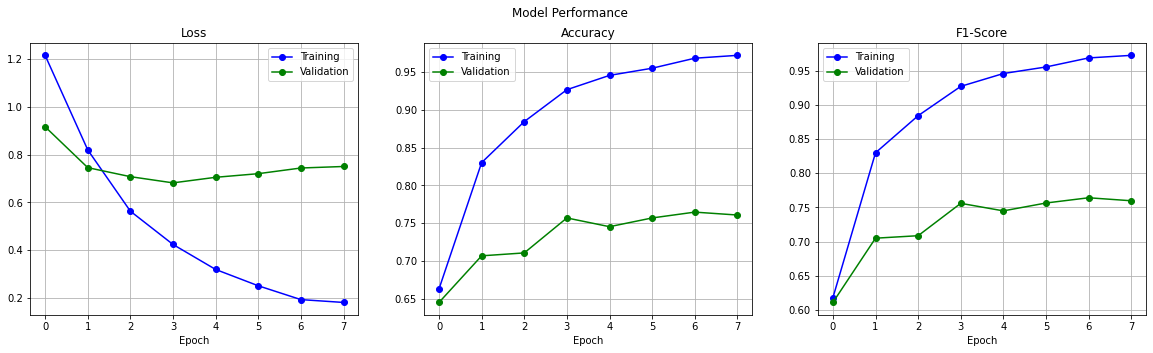

####### Report on  Validation  #######

Accuracy per class:
Class: Discuss
Accuracy: 79/102

Class: Unrelated
Accuracy: 68/84

Class: Agree
Accuracy: 36/52

Class: Disagree
Accuracy: 14/21

************************

Classification Report: 
               precision    recall  f1-score   support

           0       0.75      0.77      0.76       102
           1       0.76      0.81      0.79        84
           2       0.78      0.69      0.73        52
           3       0.74      0.67      0.70        21

    accuracy                           0.76       259
   macro avg       0.76      0.74      0.75       259
weighted avg       0.76      0.76      0.76       259

************************

Confusion Matrix: 

[[79 15  6  2]
 [11 68  4  1]
 [ 8  6 36  2]
 [ 7  0  0 14]]


loss on test set:  0.8731978952884674
f1 on test set:  0.7557127917343116
acc on test set:  0.7573770491803279


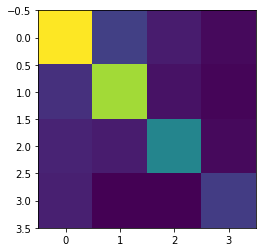

In [ ]:
# with schedular
lr= 7.187817806646779e-06
optimizer_choice='AdamW'
eps=1e-8
number_of_epochs=8
batch_size=16

training_status_sch, predictions_sch, true_vals_sch, dataloader_test_sch, model_sch = run_model()

In [ ]:
# with schedular
lr= 4.619056021613762e-05
optimizer_choice='AdamW'
eps=1e-8
number_of_epochs=8
batch_size=16

training_status_sch_2, predictions_sch_2, true_vals_sch_2, dataloader_test_sch_2, model_sch_2 = run_model()

In [ ]:
# with schedular
lr= 4.619056021613762e-04
optimizer_choice='AdamW'
eps=1e-8
number_of_epochs=8
batch_size=16

training_status_sch_3, predictions_sch_3, true_vals_sch_3, dataloader_test_sch_3, model_sch_3 = run_model()

In [ ]:
# with schedular
lr= 4.619056021613762e-06
optimizer_choice='AdamW'
eps=1e-8
number_of_epochs=6
batch_size=16

training_status_sch, predictions_sch, true_vals_sch, dataloader_test_sch, model_sch = run_model()

In [ ]:
# with schedular
lr= 4.619056021613762e-06
optimizer_choice='AdamW'
eps=1e-8
number_of_epochs=8
batch_size=16

training_status_sch_4, predictions_sch_4, true_vals_sch_4, dataloader_test_sch_4, model_sch_4 = run_model()

In [ ]:
# without schedular
lr= 4.619056021613762e-06
optimizer_choice='AdamW'
eps=1e-8
number_of_epochs=8
batch_size=16

training_status_4, predictions_4, true_vals_4, dataloader_test_4, model_4 = run_model()

In [ ]:
# with schedular
# lr= 4.619056021613762e-06
# optimizer_choice='AdamW'
# eps=1e-8
# number_of_epochs=6
# batch_size=16


save_path = '/content/drive/MyDrive/Stance Detection/Own/'
# import joblib
# joblib.dump(whole_configurations, save_path +"whole_configurations6.pkl")
joblib.dump(training_status_sch, save_path +"whole_training_status_au_mixed_sch_lr-e6_ep6_bs16.pkl")
joblib.dump(predictions_sch, save_path +"whole_validation_predictions_au_mixed_sch_lr-e6_ep6_bs16.pkl")
joblib.dump(true_vals_sch, save_path +"whole_true_values_au_mixed_sch_lr-e6_ep6_bs16.pkl")
joblib.dump(dataloader_test_sch, save_path +"whole_test_dataloaders_au_mixed_sch_lr-e6_ep6_bs16.pkl")
joblib.dump(model_sch, save_path +"whole_final_model_au_mixed_sch_lr-e6_ep6_bs16.pkl")

['/content/drive/MyDrive/Stance Detection/Own/whole_final_model_au_mixed_sch_lr-e6_ep6_bs16.pkl']

In [ ]:
clm1 = "واژگون کردن مجسمه حکیم ابوالقاسم فردوسی در حیاط دانشگاه فردوسی مشهد"
hdln1 = "این مجسمه اوایل دهه ۱۳۷۰ مقابل دانشکده مهندسی سابق دانشگاه فردوسی مشهد نصب شد و سال ۱۳۷۷ و با انتقال این دانشکده، برداشته و پشت دانشکده برای چند روزی رها شد."
clean_clm1 = clean_sentence(clm1)
clean_hdln1 = clean_sentence(hdln1)
print(clean_clm1)
print(clean_hdln1)

واژگون کردن مجسمه حکیم ابوالقاسم فردوسی در حیاط دانشگاه فردوسی مشهد
این مجسمه اوایل دهه ۱۳۷۰ مقابل دانشکده مهندسی سابق دانشگاه فردوسی مشهد نصب شد و سال ۱۳۷۷ و با انتقال این دانشکده برداشته و پشت دانشکده برای چند روزی رها شد


In [ ]:
clm2 = "جنگی که فقط ۳ ساعت طول کشید !"
hdln2 = "هیچ درگیری در جزایر ۳ گانه گزارش نشده و درگیری ۲۱ بهمن در حوالی رضا آباد در استان ایلام رخ داد، نه خوزستان یا هرمزگان!"
clean_clm2 = clean_sentence(clm2)
clean_hdln2 = clean_sentence(hdln2)
print(clean_clm2)
print(clean_hdln2)

جنگی که فقط ۳ ساعت طول کشید 
هیچ درگیری در جزایر ۳ گانه گزارش نشده و درگیری ۲۱ بهمن در حوالی رضا آباد در استان ایلام رخ داد نه خوزستان یا هرمزگان


In [ ]:
clean_clm = [clean_clm1, clean_clm2]
clean_hdln = [clean_hdln1, clean_hdln2]

In [ ]:
df = pd.DataFrame()
df['clean_claim'] = clean_clm
df['clean_headline'] = clean_hdln
df['label'] = 3
df.head()

,clean_claim,clean_headline,label
0,واژگون کردن مجسمه حکیم ابوالقاسم فردوسی در حیا...,این مجسمه اوایل دهه ۱۳۷۰ مقابل دانشکده مهندسی ...,3
1,جنگی که فقط ۳ ساعت طول کشید,هیچ درگیری در جزایر ۳ گانه گزارش نشده و درگیری...,3


In [ ]:
data = create_tensor_dataset(df)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


In [ ]:
dataloader = DataLoader(data, 
                                sampler=SequentialSampler(data), 
                                batch_size=2)

In [ ]:
val_loss, predictions, true_vals, validation_time = evaluate(model_4, dataloader)

In [ ]:
val_f1 = f1_score_func(predictions, true_vals)
val_acc = flat_accuracy(predictions, true_vals)

In [ ]:
predictions

array([[-0.21192035,  2.9032311 , -0.4371116 , -1.1697037 ],
       [-1.3486879 ,  2.8367033 , -2.3015432 ,  0.46307743]],
      dtype=float32)

{'Model': 'BERT', 'Optimizer': 'AdamW', 'Epochs': 6, 'Batch size': 16, 'Learning rate': 4.619056021613762e-06, 'Momentum/Eps': 1e-08}


Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

----------------------------------------------------------------



Loading model is done!
DataLoader declaration is done!
Optimizer was selected!

Start Training...


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 1

Training loss: 1.2681086081447024
Validation loss: 1.0389489706824808
Training eval Acc.: 0.5786481364497789
Validation Acc.: 0.5714285714285714
Training eval F1 Score (Weighted): 0.48650359141631033
Validation F1 Score (Weighted): 0.4962662340448586
Training this epoch took: 0:00:31


Epoch 2:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 2

Training loss: 0.9511070414022966
Validation loss: 0.7972958981990814
Training eval Acc.: 0.8085912823752369
Validation Acc.: 0.6911196911196911
Training eval F1 Score (Weighted): 0.8083249535769468
Validation F1 Score (Weighted): 0.6892231516998844
Training this epoch took: 0:00:31


Epoch 3:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 3

Training loss: 0.659693892857041
Validation loss: 0.7297052048584994
Training eval Acc.: 0.8578648136449779
Validation Acc.: 0.694980694980695
Training eval F1 Score (Weighted): 0.8577261785197464
Validation F1 Score (Weighted): 0.6946066093587097
Training this epoch took: 0:00:31


Epoch 4:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 4

Training loss: 0.5001741772649264
Validation loss: 0.6963614120202906
Training eval Acc.: 0.9084017687934302
Validation Acc.: 0.7258687258687259
Training eval F1 Score (Weighted): 0.9086563041086685
Validation F1 Score (Weighted): 0.7246443620279641
Training this epoch took: 0:00:31


Epoch 5:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 5

Training loss: 0.3712093617879983
Validation loss: 0.7013074093881775
Training eval Acc.: 0.9450410612760581
Validation Acc.: 0.7335907335907336
Training eval F1 Score (Weighted): 0.9450220003383947
Validation F1 Score (Weighted): 0.7329385378131091
Training this epoch took: 0:00:31


Epoch 6:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 6

Training loss: 0.26880894808305633
Validation loss: 0.7357494980096817
Training eval Acc.: 0.9620972836386608
Validation Acc.: 0.749034749034749
Training eval F1 Score (Weighted): 0.9621635023435917
Validation F1 Score (Weighted): 0.748676227631807
Training this epoch took: 0:00:31
Training Done!
Total training took 0:03:58 (h:mm:ss)



%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%




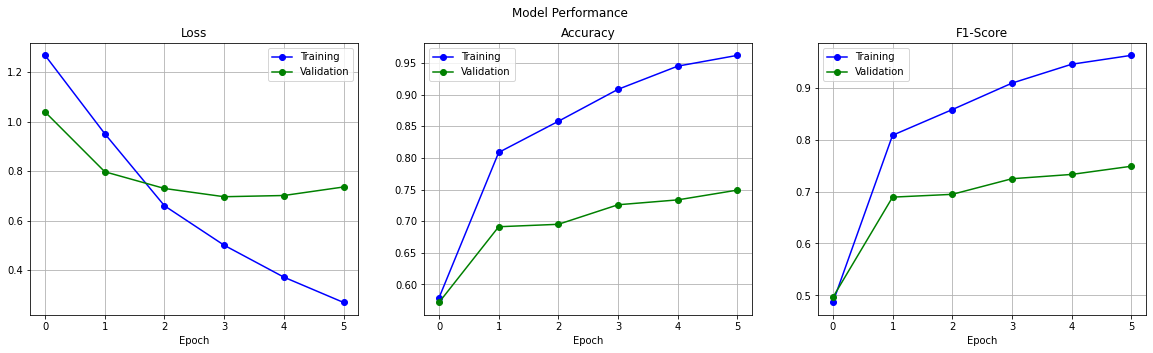

####### Report on  Validation  #######

Accuracy per class:
Class: Discuss
Accuracy: 77/102

Class: Unrelated
Accuracy: 66/84

Class: Agree
Accuracy: 37/52

Class: Disagree
Accuracy: 14/21

************************

Classification Report: 
               precision    recall  f1-score   support

           0       0.75      0.75      0.75       102
           1       0.77      0.79      0.78        84
           2       0.73      0.71      0.72        52
           3       0.74      0.67      0.70        21

    accuracy                           0.75       259
   macro avg       0.74      0.73      0.74       259
weighted avg       0.75      0.75      0.75       259

************************

Confusion Matrix: 

[[77 14  8  3]
 [11 66  6  1]
 [ 8  6 37  1]
 [ 7  0  0 14]]


loss on test set:  0.8045729577541352
f1 on test set:  0.7436102813584666
acc on test set:  0.7442622950819672


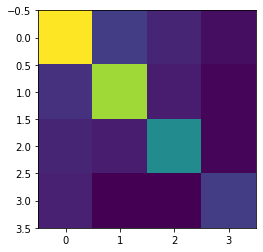

In [ ]:
# without schedular
lr= 4.619056021613762e-06
optimizer_choice='AdamW'
eps=1e-8
number_of_epochs=6
batch_size=16

training_status, predictions, true_vals, dataloader_test, model = run_model()

In [ ]:
save_path = '/content/drive/MyDrive/Stance Detection/Own/'
# import joblib
# joblib.dump(whole_configurations, save_path +"whole_configurations6.pkl")
joblib.dump(training_status, save_path +"whole_training_status_au_mixed_lr-e6_ep6_bs16_2.pkl")
joblib.dump(predictions, save_path +"whole_validation_predictions_au_mixed_lr-e6_ep6_bs16_2.pkl")
joblib.dump(true_vals, save_path +"whole_true_values_au_mixed_lr-e6_ep6_bs16_2.pkl")
joblib.dump(dataloader_test, save_path +"whole_test_dataloaders_au_mixed_lr-e6_ep6_bs16_2.pkl")
# joblib.dump(model_sch, save_path +"whole_final_model_au_mixed_lr-e6_ep6_bs16_2.pkl")

['/content/drive/MyDrive/Stance Detection/Own/whole_test_dataloaders_au_mixed_lr-e6_ep6_bs16_2.pkl']

{'Model': 'BERT', 'Optimizer': 'AdamW', 'Epochs': 6, 'Batch size': 16, 'Learning rate': 4.619056021613762e-06, 'Momentum/Eps': 1e-08}


Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

----------------------------------------------------------------



Loading model is done!
DataLoader declaration is done!
Optimizer was selected!
Schedular is set!

Start Training...


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 1

Training loss: 1.2345439918113477
Validation loss: 1.0662047372144812
Training eval Acc.: 0.5672773215413771
Validation Acc.: 0.5366795366795367
Training eval F1 Score (Weighted): 0.45896535285470247
Validation F1 Score (Weighted): 0.4528756667484991
Training this epoch took: 0:00:31


Epoch 2:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 2

Training loss: 1.0503688075325706
Validation loss: 0.9922953423331765
Training eval Acc.: 0.6317119393556538
Validation Acc.: 0.5714285714285714
Training eval F1 Score (Weighted): 0.5534150504470373
Validation F1 Score (Weighted): 0.49260226562587467
Training this epoch took: 0:00:31


Epoch 3:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 3

Training loss: 0.8749687996777621
Validation loss: 0.8752355417784523
Training eval Acc.: 0.770056854074542
Validation Acc.: 0.6640926640926641
Training eval F1 Score (Weighted): 0.7600845214246102
Validation F1 Score (Weighted): 0.6480824787098988
Training this epoch took: 0:00:31


Epoch 4:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 4

Training loss: 0.718708321301624
Validation loss: 0.8036690547185785
Training eval Acc.: 0.8351231838281743
Validation Acc.: 0.7104247104247104
Training eval F1 Score (Weighted): 0.8341761654467422
Validation F1 Score (Weighted): 0.7088387168870065
Training this epoch took: 0:00:31


Epoch 5:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 5

Training loss: 0.6264968827517345
Validation loss: 0.7797974225352792
Training eval Acc.: 0.8496525584333544
Validation Acc.: 0.7181467181467182
Training eval F1 Score (Weighted): 0.8491972699837147
Validation F1 Score (Weighted): 0.717562605672142
Training this epoch took: 0:00:31


Epoch 6:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 6

Training loss: 0.5800229485588845
Validation loss: 0.7734133916742661
Training eval Acc.: 0.8559696778269109
Validation Acc.: 0.7142857142857143
Training eval F1 Score (Weighted): 0.8558780251977016
Validation F1 Score (Weighted): 0.7133478374597065
Training this epoch took: 0:00:31
Training Done!
Total training took 0:03:59 (h:mm:ss)



%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%




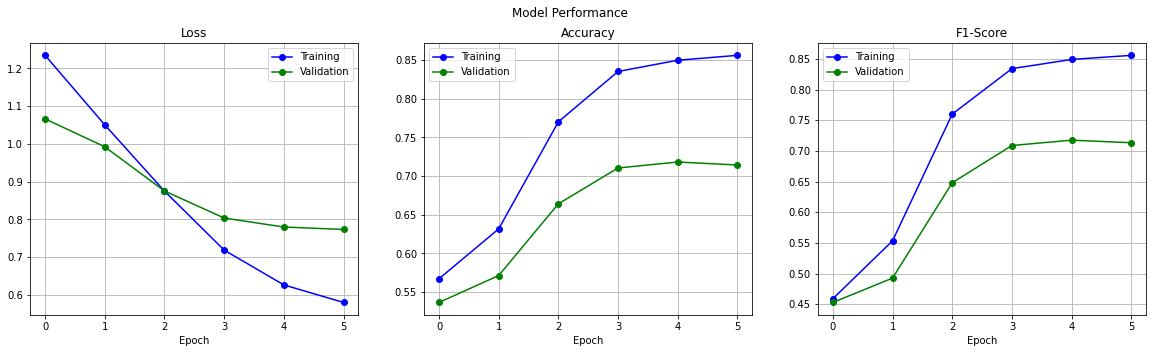

####### Report on  Validation  #######

Accuracy per class:
Class: Discuss
Accuracy: 73/102

Class: Unrelated
Accuracy: 66/84

Class: Agree
Accuracy: 34/52

Class: Disagree
Accuracy: 12/21

************************

Classification Report: 
               precision    recall  f1-score   support

           0       0.71      0.72      0.71       102
           1       0.70      0.79      0.74        84
           2       0.79      0.65      0.72        52
           3       0.63      0.57      0.60        21

    accuracy                           0.71       259
   macro avg       0.71      0.68      0.69       259
weighted avg       0.72      0.71      0.71       259

************************

Confusion Matrix: 

[[73 19  5  5]
 [12 66  4  2]
 [10  8 34  0]
 [ 8  1  0 12]]


loss on test set:  0.8084571182727813
f1 on test set:  0.7203250800202283
acc on test set:  0.7213114754098361


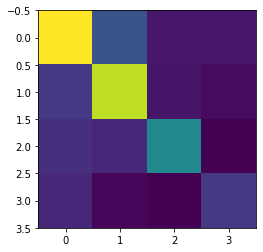

In [ ]:
# with schedular
lr= 4.619056021613762e-06
optimizer_choice='AdamW'
eps=1e-8
number_of_epochs=6
batch_size=16

training_status_sch, predictions_sch, true_vals_sch, dataloader_test_sch, model_sch = run_model()

In [ ]:
save_path = '/content/drive/MyDrive/Stance Detection/Own/'
# import joblib
# joblib.dump(whole_configurations, save_path +"whole_configurations6.pkl")
joblib.dump(training_status_sch, save_path +"whole_training_status_au_mixed_sch_lr-e6_ep6_bs16_2.pkl")
joblib.dump(predictions_sch, save_path +"whole_validation_predictions_au_mixed_sch_lr-e6_ep6_bs16_2.pkl")
joblib.dump(true_vals_sch, save_path +"whole_true_values_au_mixed_sch_lr-e6_ep6_bs16_2.pkl")
joblib.dump(dataloader_test_sch, save_path +"whole_test_dataloaders_au_mixed_sch_lr-e6_ep6_bs16_2.pkl")
joblib.dump(model_sch, save_path +"whole_final_model_au_mixed_sch_lr-e6_ep6_bs16_2.pkl")

['/content/drive/MyDrive/Stance Detection/Own/whole_final_model_au_mixed_sch_lr-e6_ep6_bs16_2.pkl']

Multilingual BERT

{'Model': 'BERT', 'Optimizer': 'AdamW', 'Epochs': 8, 'Batch size': 16, 'Learning rate': 7.187817806646779e-06, 'Momentum/Eps': 1e-08}


Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/681M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

----------------------------------------------------------------



Loading model is done!
DataLoader declaration is done!
Optimizer was selected!
Schedular is set!

Start Training...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 1

Training loss: 1.250167879191312
Validation loss: 1.054006278514862
Training eval Acc.: 0.5476942514213519
Validation Acc.: 0.5752895752895753
Training eval F1 Score (Weighted): 0.483490713601487
Validation F1 Score (Weighted): 0.5385143708078787
Training this epoch took: 0:00:31


Epoch 2:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 2

Training loss: 1.1372215952536073
Validation loss: 1.0145748187513912
Training eval Acc.: 0.5837018319646241
Validation Acc.: 0.5752895752895753
Training eval F1 Score (Weighted): 0.5207109806769237
Validation F1 Score (Weighted): 0.536029126921389
Training this epoch took: 0:00:31


Epoch 3:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 3

Training loss: 1.0520786739358998
Validation loss: 0.9819282205665812
Training eval Acc.: 0.660770688566014
Validation Acc.: 0.5984555984555985
Training eval F1 Score (Weighted): 0.6040272299524606
Validation F1 Score (Weighted): 0.566189676605637
Training this epoch took: 0:00:31


Epoch 4:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 4

Training loss: 0.9661058903944613
Validation loss: 0.976418789695291
Training eval Acc.: 0.691724573594441
Validation Acc.: 0.5907335907335908
Training eval F1 Score (Weighted): 0.6457993460273288
Validation F1 Score (Weighted): 0.5562780223330682
Training this epoch took: 0:00:32


Epoch 5:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 5

Training loss: 0.9011281611341418
Validation loss: 0.9324248152620652
Training eval Acc.: 0.7409981048641819
Validation Acc.: 0.6023166023166023
Training eval F1 Score (Weighted): 0.7126072947895792
Validation F1 Score (Weighted): 0.5818347344877958
Training this epoch took: 0:00:32


Epoch 6:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 6

Training loss: 0.8459520951063946
Validation loss: 0.9098727054455701
Training eval Acc.: 0.7567909033480733
Validation Acc.: 0.6254826254826255
Training eval F1 Score (Weighted): 0.7364102449200267
Validation F1 Score (Weighted): 0.6057429615503445
Training this epoch took: 0:00:32


Epoch 7:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 7

Training loss: 0.7851452550502739
Validation loss: 0.9076517671346664
Training eval Acc.: 0.7915350600126342
Validation Acc.: 0.6254826254826255
Training eval F1 Score (Weighted): 0.7814499329764275
Validation F1 Score (Weighted): 0.6146692752295664
Training this epoch took: 0:00:32


Epoch 8:   0%|          | 0/99 [00:00<?, ?it/s]


Epoch 8

Training loss: 0.7409082666189983
Validation loss: 0.900805305908708
Training eval Acc.: 0.8035375868603917
Validation Acc.: 0.637065637065637
Training eval F1 Score (Weighted): 0.7947716263502763
Validation F1 Score (Weighted): 0.6268292445203989
Training this epoch took: 0:00:32
Training Done!
Total training took 0:05:20 (h:mm:ss)



%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%




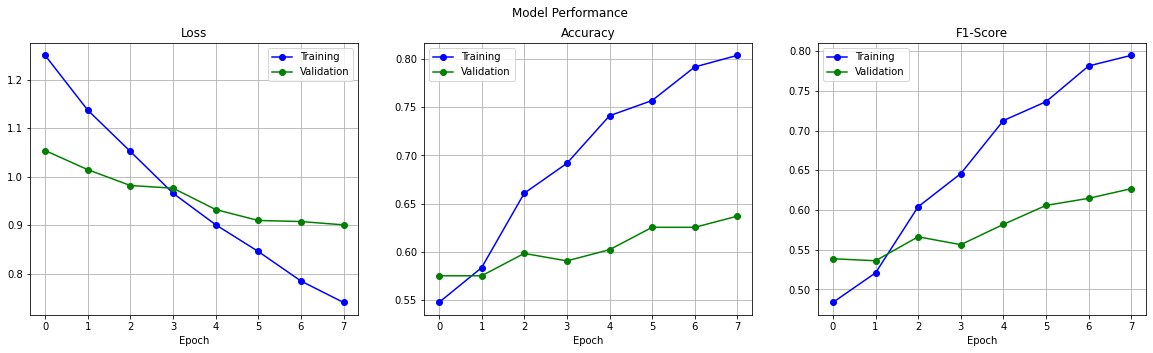

####### Report on  Validation  #######

Accuracy per class:
Class: Discuss
Accuracy: 64/102

Class: Unrelated
Accuracy: 67/84

Class: Agree
Accuracy: 29/52

Class: Disagree
Accuracy: 5/21

************************

Classification Report: 
               precision    recall  f1-score   support

           0       0.60      0.63      0.62       102
           1       0.64      0.80      0.71        84
           2       0.72      0.56      0.63        52
           3       0.62      0.24      0.34        21

    accuracy                           0.64       259
   macro avg       0.65      0.56      0.57       259
weighted avg       0.64      0.64      0.63       259

************************

Confusion Matrix: 

[[64 30  6  2]
 [15 67  2  0]
 [15  7 29  1]
 [12  1  3  5]]


loss on test set:  0.9417087703943252
f1 on test set:  0.6496400129332277
acc on test set:  0.659016393442623


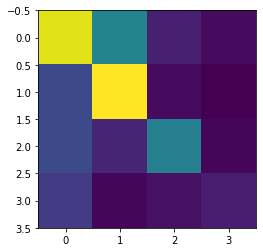

In [ ]:
MODEL_NAME_OR_PATH = 'bert-base-multilingual-cased'
lr= 7.187817806646779e-06
optimizer_choice='AdamW'
eps=1e-8
number_of_epochs=8
batch_size=16

training_status_sch, predictions_sch, true_vals_sch, dataloader_test_sch, model_sch = run_model()